In [159]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from KDEpy import FFTKDE
from tqdm.auto import tqdm
from math import ceil
import itertools
import scipy
from fast_histogram import histogram2d
import colorcet as cc
import matplotlib.colors as colors
import h5py
import io
import cloudpickle as cpl
from collections import defaultdict
import os

lmap = lambda func, *iterable: list(map(func, *iterable))

In [2]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

cmap = LinearSegmentedColormap.from_list("CyanOrange", ["C0", "white", "C1"])
mpl.colormaps.register(cmap)

In [3]:
dataset_path = "/data/output/20220226_robustness/dataset.h5"

#### Normalize by scale

In [ ]:
with h5py.File(dataset_path, "r") as f:
    dX = f["filters"][:].reshape(-1, 9) 

In [9]:
def scale(X):
    den = np.linalg.norm(X, np.inf, axis=1)
    den = np.where(den == 0, 1, den)[:, None]
    return X / den

dX = scale(dX)

In [52]:
def set_dataset(file, key, value, overwrite=True):
    if key not in file:
        file.create_dataset(key, data=value)
    elif overwrite:
        del file[key]
        file[key] = value
        
with h5py.File(dataset_path, "a") as f:
    set_dataset(f, "scaled_filters", dX)

#### Load scaled

In [4]:
with h5py.File(dataset_path, "r") as f:
    dX = f["scaled_filters"][:]

In [8]:
sparse_ids = set(np.load("sparse_filter_ids.npy"))

In [124]:
df_meta = pd.read_hdf(dataset_path, "meta")
df_meta["filter_ids"] = df_meta["filter_ids"].apply(lambda s: list(set(np.arange(int(s.split(":")[0]), 1 + int(s.split(":")[1]))) - sparse_ids))
df_meta.Robust = df_meta.Robust.apply(bool)

In [9]:
non_sparse_mask = np.ones(len(dX), bool)
non_sparse_mask[list(sparse_ids)] = 0

In [10]:
df_pairings = pd.read_csv("robust_vs_normal_pairings.csv", index_col=0)
all_used_model_names = pd.concat([df_pairings.Robust, df_pairings.Normal]).unique()

In [11]:
pca_dict = {}

In [12]:
if os.path.exists("pca_dict.cpkl"):    
    with open("pca_dict.cpkl", "rb") as f:
        pca_dict = cpl.load(f) 

In [55]:
for model in tqdm(all_used_model_names):
    ids = list(np.hstack(df_meta[df_meta.Name == model].filter_ids))
    pca_dict[model] = PCA(n_components=9).fit(dX[ids])

  0%|          | 0/114 [00:00<?, ?it/s]

In [58]:
ids = list(np.hstack(df_meta[df_meta.Name.isin(all_used_model_names)].filter_ids))
pca_dict["full"] = PCA(n_components=9).fit(dX[ids])

In [59]:
ids = list(np.hstack(df_meta[df_meta.Name.isin(df_pairings.Robust)].filter_ids))
pca_dict["robust"] = PCA(n_components=9).fit(dX[ids])

In [60]:
ids = list(np.hstack(df_meta[df_meta.Name.isin(df_pairings.Normal)].filter_ids))
pca_dict["normal"] = PCA(n_components=9).fit(dX[ids])

In [61]:
with open("pca_dict.cpkl", "wb") as f:
    cpl.dump(pca_dict, f) 

In [11]:
def plot_basis(pca):
    fig, axes = plt.subplots(1, 9, figsize=(9, 1))
    
    t = np.abs(pca.components_).max()
    
    for i, (ax, c, ratio) in enumerate(zip(axes, pca.components_.reshape(-1, 3, 3), pca.explained_variance_ratio_)):
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        im = ax.imshow(c, vmin=-t, vmax=t, cmap="CyanOrange")
        ax.set_title(f"$v_{i}$", fontweight='bold', fontsize=18)
        ax.set_xlabel(f"{ratio:.2f}", fontsize=18)

    cb_ax = fig.add_axes([0.8275, 0.15, 0.1, 0.7])    
    cb_ax.axis("off")
    cb = fig.colorbar(im, ax=cb_ax, aspect=10)
    cb.outline.set_visible(False)

In [12]:
def plot_cumsum_variance(pcas, labels):
    fig = plt.figure(figsize=([8, 5]))
    colors = cc.glasbey_category10
    
    for i, (pca, label) in enumerate(zip(pcas, labels)):
        plt.plot(range(1, 10), np.cumsum(pca.explained_variance_ratio_), label=label, color=colors[i])
    
    plt.ylabel("cumulative share of explained variance")
    plt.xlabel("principal components")
    plt.grid()
    plt.legend()

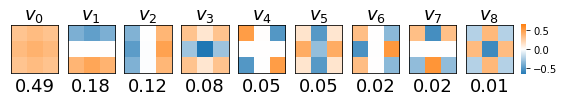

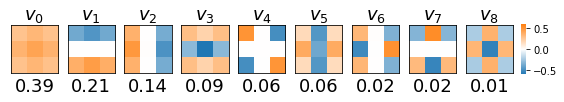

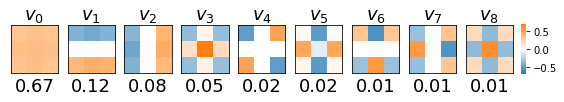

In [75]:
plot_basis(pca_dict["full"])
plt.savefig("plots/pca_basis_full.pdf", bbox_inches='tight')
plt.show()
plot_basis(pca_dict["robust"])
plt.savefig("plots/pca_basis_robust.pdf", bbox_inches='tight')
plt.show()
plot_basis(pca_dict["normal"])
plt.savefig("plots/pca_basis_normal.pdf", bbox_inches='tight')
plt.show()

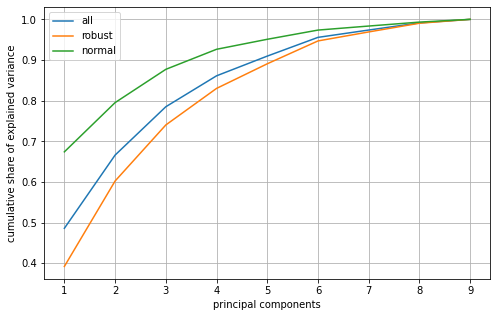

In [76]:
plot_cumsum_variance([pca_dict["full"], pca_dict["robust"], pca_dict["normal"]], ["all", "robust", "normal"])
plt.savefig("plots/pca_cumsum.pdf", bbox_inches='tight')

In [13]:
dX_trans = pca_dict["full"].transform(dX)

In [14]:
dX_trans_range = dX_trans.min(), dX_trans.max()

In [15]:
del dX

In [14]:
def ridge_plot(X, xrange, shape, row_labels=None, col_labels=None, figsize=(40, 10)):
    gs = grid_spec.GridSpec(*shape)
    fig = plt.figure(figsize=figsize)

    ax_objs = []
    for i in tqdm(range(shape[0])):
        for j in range(shape[1]):

            data = X[i][j]            
            dx, dy = FFTKDE(kernel="gaussian", bw='silverman').fit(data).evaluate()

            color = f"C{i%2}"
            
            # creating new axes object
            ax_objs.append(fig.add_subplot(gs[i:i+1, j:j+1]))

            # plotting the distribution
            ax_objs[-1].plot(dx, dy, color="#f0f0f0", lw=1)
            ax_objs[-1].fill_between(dx, dy, alpha=.7, color=color)

            # setting uniform x and y lims
            ax_objs[-1].set_xlim(*xrange)

            # make background transparent
            ax_objs[-1].patch.set_alpha(0)

            # remove borders, axis ticks, and labels
            ax_objs[-1].set_yticklabels([])
            ax_objs[-1].set_yticks([])
            ax_objs[-1].set_ylim([0, None])

            for s in ["top", "right", "left", "bottom"]:
                ax_objs[-1].spines[s].set_visible(False)
            
            if i == shape[0] - 1:
                ax_objs[-1].tick_params(direction="inout")
                ax_objs[-1].spines["bottom"].set_visible(True)
                
                if col_labels is not None:
                    ax_objs[-1].set_xlabel(col_labels[j])
            else:
                ax_objs[-1].set_xticks([])
                ax_objs[-1].set_xticklabels([])

            if j == 0 and row_labels is not None:
                ax_objs[-1].text(xrange[0] - 0.1, 0, row_labels[i], ha="right", wrap=True, color=color)

    gs.update(hspace=-0.5)

In [18]:
distributions_dataset_robustness = df_meta[df_meta.Name.isin(all_used_model_names)].groupby(["Training-Dataset", "Robust"]).filter_ids.apply(np.hstack) 

  0%|          | 0/6 [00:00<?, ?it/s]

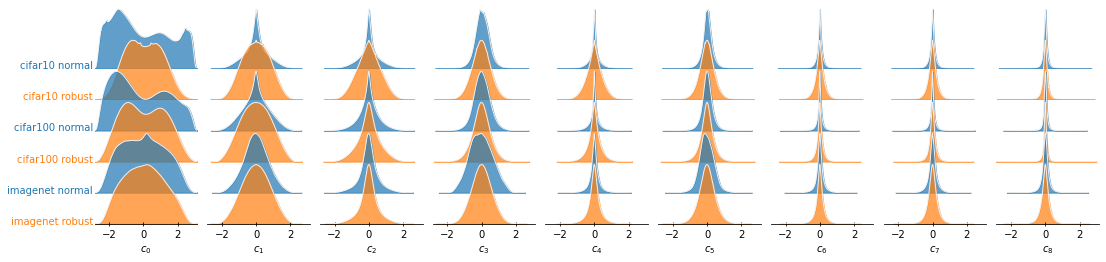

In [18]:
figsize=(18, 1 + 0.5 * len(distributions_dataset_robustness))
ridge_plot([dX_trans[v].T for v in distributions_dataset_robustness.values], xrange=dX_trans_range, 
           shape=(len(distributions_dataset_robustness), 9), 
           row_labels=[x[0] + " " + str(x[1]).replace("False", "normal").replace("True", "robust") for x in distributions_dataset_robustness.index], 
           col_labels=lmap(lambda i: f"$c_{i}$", range(9)), 
           figsize=figsize)
plt.subplots_adjust(hspace=0, wspace=0.1)
plt.savefig("plots/ridge_dataset_by_robust.pdf", bbox_inches='tight')

In [47]:
def kl_sym(p, q):
    return scipy.stats.entropy(p, q) + scipy.stats.entropy(q, p)

def nd_kl_sym(p, q, weights=None):
    if type(p) is not list and len(p.shape) == 1:
        return kl_sym(p, q)
    else:
        return np.sum(lmap(lambda i: weights[i] * kl_sym(p[i], q[i]), range(len(p))))

def get_kl_matrix(data, bins, x_range, weights=None):
    d = len(data)
    kl_matrix = np.zeros((d, d))
    lookup = dict()
    for p, q in tqdm(itertools.product(range(d), repeat=2), total=d**2):
        if p not in lookup:
            lookup[p] = get_nd_discrete_probability_distribution(data[p], x_range, bins)
        if q not in lookup:
            lookup[q] = get_nd_discrete_probability_distribution(data[q], x_range, bins)
                
        kl_matrix[p, q] = nd_kl_sym(lookup[p], lookup[q], weights=weights)
    return kl_matrix

def get_discrete_probability_distribution(X, _range, bins):
    v, _ = np.histogram(X, range=_range, bins=bins, density=True)  # density will not sum to 1 but help to not underflow eps during normalization
    v = v.astype(np.double) 
    v[v == 0] = np.finfo(np.float32).eps
    v = v / np.sum(v)
    return v

def get_nd_discrete_probability_distribution(X, _range, bins):
    if type(X) is not list and len(X.shape) == 1:
        return get_discrete_probability_distribution(X, _range, bins)
    else:
        dims = list()
        for x in X:
            v = get_discrete_probability_distribution(x, _range, bins)
            dims.append(v)
        return np.vstack(dims)

def kl_plot(s, figsize=(10, 10), ax=None, sort=True, **kwargs):
    created = False
    if ax is None:
        created = True
        plt.figure(figsize=figsize)
        ax = plt.gca()
    
    img = get_kl_matrix(s.values, **kwargs)
    labels = s.index
    if sort:
        sort_index = np.argsort(np.mean(img, axis=0))
        img = img[sort_index][:, sort_index]
        labels = labels[sort_index]
    
    cim = ax.imshow(img, cmap=cc.cm["fire"])
    ax.set_xticks(range(len(s)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticks(range(len(s)))
    ax.set_yticklabels(labels, rotation=0)
    
    if created:
        plt.colorbar(cim)
    
    return ax, img

In [152]:
for dataset in df_pairings.Dataset.unique():
    df_pairs = df_pairings[df_pairings.Dataset == dataset].copy()
    robust_ids = np.hstack(df_meta.reset_index().set_index("model").loc[list(df_pairs.Robust.values)].filter_ids)
    normal_ids = np.hstack(df_meta.reset_index().set_index("model").loc[list(df_pairs.Normal.values)].filter_ids)

    robust_distr = get_nd_discrete_probability_distribution(dX_trans[robust_ids].T, _range=dX_trans_range, bins=70)
    normal_distr = get_nd_discrete_probability_distribution(dX_trans[normal_ids].T, _range=dX_trans_range, bins=70)
    
    kl = np.sum([pca_dict["full"].explained_variance_ratio_[i] * kl_sym(x, y) for i, (x, y) in enumerate(zip(robust_distr, normal_distr))])
    
    print(dataset, kl)

cifar10 0.6220390905319085
cifar100 0.1742469941359503
imagenet 0.031359640448784316


In [160]:
dataset_depth_kl_dict = defaultdict(list)

for dataset in df_pairings.Dataset.unique():
    df_pairs = df_pairings[df_pairings.Dataset == dataset].copy()
    
    df = df_meta.reset_index().set_index("model").loc[list(df_pairs.Normal.values)]
    normal_ids_by_depth = df.groupby(pd.cut(df["conv_depth_norm"], np.arange(0, 1.0+0.10, 0.10))).filter_ids.apply(np.hstack)
    
    df = df_meta.reset_index().set_index("model").loc[list(df_pairs.Robust.values)]
    robust_ids_by_depth = df.groupby(pd.cut(df["conv_depth_norm"], np.arange(0, 1.0+0.10, 0.10))).filter_ids.apply(np.hstack)
    
    for normal_ids, robust_ids in tqdm(zip(normal_ids_by_depth, robust_ids_by_depth)):
        robust_distr = get_nd_discrete_probability_distribution(dX_trans[robust_ids].T, _range=dX_trans_range, bins=70)
        normal_distr = get_nd_discrete_probability_distribution(dX_trans[normal_ids].T, _range=dX_trans_range, bins=70)

        kl = np.sum([pca_dict["full"].explained_variance_ratio_[i] * kl_sym(x, y) for i, (x, y) in enumerate(zip(robust_distr, normal_distr))])
        dataset_depth_kl_dict[dataset].append(kl)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

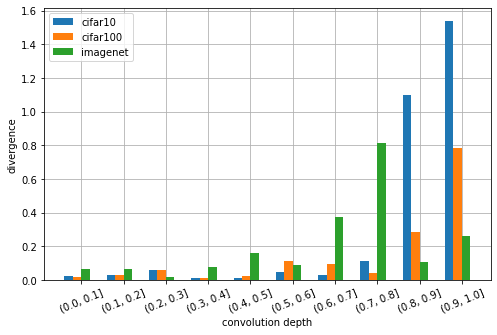

In [189]:
plt.figure(figsize=([8, 5]))
ind = np.arange(3)
width = 0.2
for i, (key, values) in enumerate(dataset_depth_kl_dict.items()):
    plt.bar(np.arange(len(values)) +  i * width, values, width, label=key, zorder=3)
plt.legend()
plt.ylabel("divergence")
plt.xlabel("convolution depth")
plt.grid(zorder=0)
plt.xticks(np.arange(10) + (width * 3) / 2, robust_ids_by_depth.index, rotation=22.5)
plt.savefig("plots/divergence_by_depth.pdf", bbox_inches='tight')

In [41]:
distributions_dataset_robustness = df_meta[df_meta.Name.isin(all_used_model_names)].groupby(["Training-Dataset", "Robust"]).filter_ids.apply(lambda x: list(set(np.hstack(x)) - sparse_ids)) 

(9, 70)

In [35]:
np.sum([pca_dict["full"].explained_variance_ratio_[i] * kl_sym(coefficient_distrs[0][i], coefficient_distrs[1][i]) for i in range(9)])

0.5535903898197891

In [37]:
np.sum([pca_dict["full"].explained_variance_ratio_[i] * kl_sym(coefficient_distrs[2][i], coefficient_distrs[3][i]) for i in range(9)])

0.16291888229022275

In [38]:
np.sum([pca_dict["full"].explained_variance_ratio_[i] * kl_sym(coefficient_distrs[4][i], coefficient_distrs[5][i]) for i in range(9)])

0.0309069277170821

  0%|          | 0/36 [00:00<?, ?it/s]

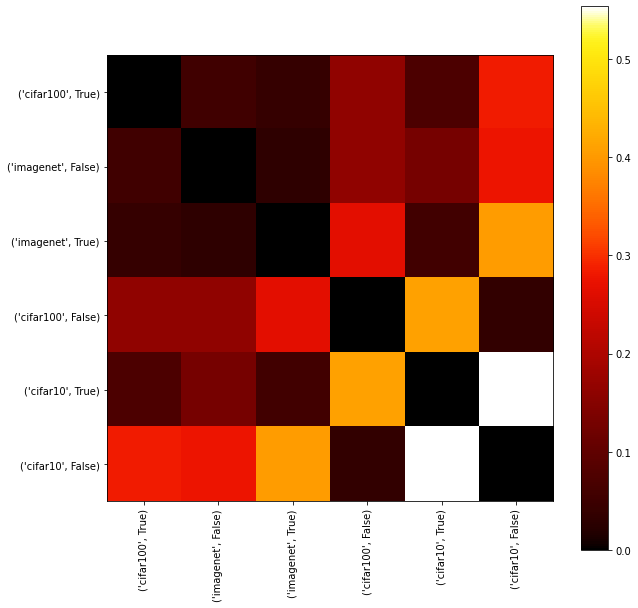

In [22]:
axes, kl_mat = kl_plot(distributions_dataset_robustness.apply(lambda ids: dX_trans[ids].T), x_range=dX_trans_range, bins=70, weights=pca_dict["full"].explained_variance_ratio_, sort=True)